In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import caveclient
import matplotlib.pyplot as plt
import datetime
from meshparty import trimesh_io,meshwork
import pcg_skel
import skeleton_plot

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


In [2]:
df = pd.read_pickle('../data/microns_SomaData_AllCells_v661.pkl')

df.columns

Index(['soma_id', 'nucleus_id', 'soma_depth_x', 'soma_depth_y', 'soma_depth_z',
       'is_column', 'nucleus_volume_um', 'nucleus_area_um',
       'nuclear_area_to_volume_ratio', 'nuclear_folding_area_um',
       'fraction_nuclear_folding', 'nucleus_to_soma_ratio', 'soma_volume_um',
       'soma_area_um', 'soma_to_nucleus_center_dist',
       'soma_area_to_volume_ratio', 'soma_synapse_number',
       'soma_synapse_density_um', 'cortical_column_labels', 'predicted_class',
       'predicted_subclass', 'umap_embedding_x', 'umap_embedding_y'],
      dtype='object')

Let's start by just taking a look at all the cells in the dataset with their predicted cell-type labels. We'll do so by projecting all the cells in to the 2D UMAP space.

In [3]:
#Custom color dictionary
color_dict = {'23P':'#8268DC',
              '4P':'#647FDC',
              '5P-IT':'#77BCDE',
              '5P-ET':'#87DD90',
              '5P-NP':'#85DEC9',
              '6P-CT':'#96DD70',
              '6P-IT':'#DCC86E',
              'BC':'#D68C66',
              'BPC':'#D3697C',
              'MC':'#D36BBA',
              'NGC':'#BC6BDB',
              'astrocyte':'#009245',
              'pericyte':'#754C24',
              'microglia':'#006837',
              'oligo':'#8CC63F',
              'OPC':'#998675',
              'error':'#899499'
    
}

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Subclass Predictions for All Cells in MICrONS v661')

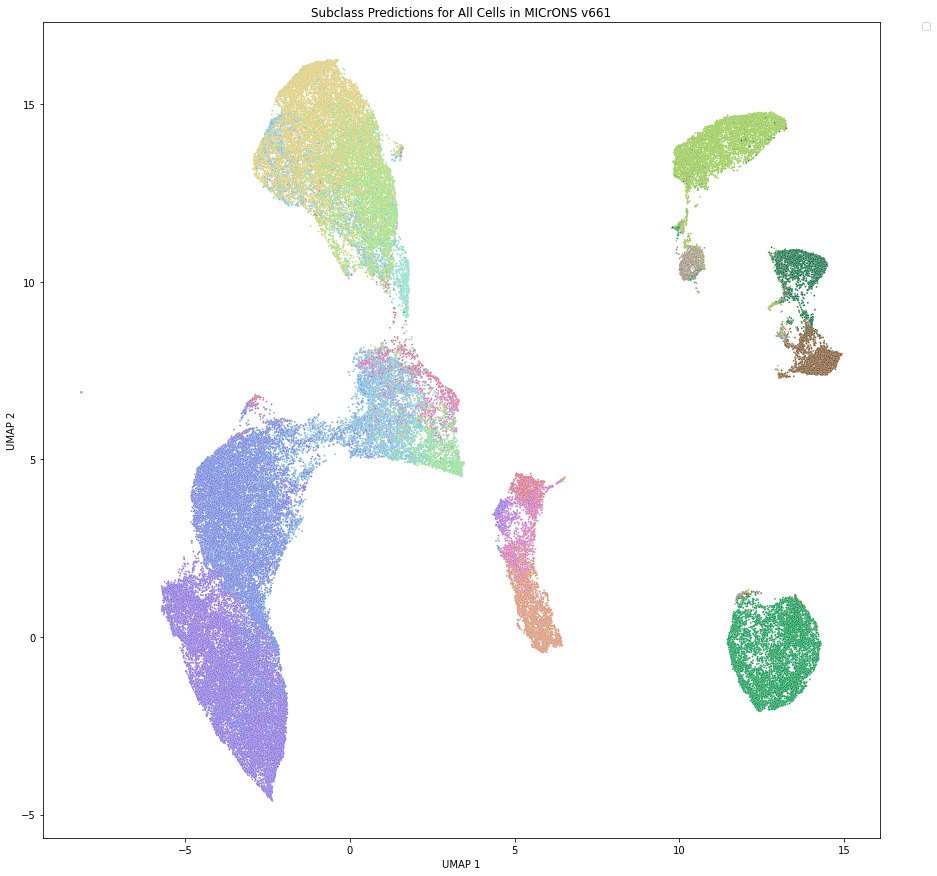

In [4]:
f,ax=plt.subplots(figsize=(15,15))

ax = sns.scatterplot(x='umap_embedding_x', y='umap_embedding_y', data=df,
                     s=3, ax=ax, legend=False, hue='predicted_subclass',
                    palette=color_dict, alpha = 1)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
ax.set_title('Subclass Predictions for All Cells in MICrONS v661')

# Exploring the downstream connectivity of individual cells

### Pick a cell of interest - this can be any nucleus ID in the cell-type table or one of the examples highlighted before.

In [155]:
# A dictionary with the nucleus IDs of all the examples highlighted in the manuscript
example_dict = {
    'chandelier':389613,
    'np_targetting':434607,
    '23P':256657,
    'BPC':258362
}

In [190]:
example_nuc_id= example_dict['BPC']  #485719 #np targetting 434607 23p 256657 PTC BPC 258362 chandelier 485719, 389613
example_root_id = df.query(f'nucleus_id=={example_nuc_id}').soma_id.iloc[0]
example_root_id

864691135783071283

### Let's set up our client to access the data and preload some helpful tables we will use along the way

In [192]:
#Setting up our client to access the data
client = caveclient.CAVEclient('minnie65_public')

#Our nucleus table with all cells with a soma within the dataset
nuc_df = client.materialize.query_table('nucleus_detection_v0', split_positions=True, 
                                       desired_resolution=(1000,1000,1000))

#Our cell-type table using the cell-class and subclass scheme applied in the manuscript
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661', 
                                       split_positions=True, desired_resolution=(1000,1000,1000))

### Download the mesh of your cell of interest

In [193]:

#This allows us to download meshes 
mm = trimesh_io.MeshMeta(cv_path=client.info.segmentation_source(), disk_cache_path='minnie_meshes')

#Download our mesh of interest, NOTE the first time you run this may take a few minutes
mesh = mm.mesh(seg_id=example_root_id)

### Now let's skeletonize the cell and add synapse information

In [194]:
#Defining our root point (the soma point in this case)
root_point = nuc_df.query(f'id=={example_nuc_id}')[['pt_position_x', 'pt_position_y', 'pt_position_z']].iloc[0,:].values

#Skeletonizing our cell of interest
v661 = datetime.datetime(2023, 4,6,0,0, tzinfo=datetime.timezone.utc) #to match the version presented in the manuscript
mw=pcg_skel.coord_space_meshwork(example_root_id, client=client, root_point=root_point, 
                                root_point_resolution=[nuc_df.attrs['dataframe_resolution']],
                                collapse_soma=True, synapses='all', 
                                synapse_table=client.materialize.synapse_table,
                                timestamp=v661)

100%|██████████| 3104/3104 [00:00<00:00, 28916.60it/s]


In [195]:
#Adding volumetric properties
pcg_skel.features.add_volumetric_properties(mw, client)
pcg_skel.features.add_segment_properties(mw)

volume_df = mw.anno.segment_properties.df
# add column indicating skel index 
volume_df['skel_index'] = mw.anno.segment_properties.mesh_index.to_skel_index_padded
sk_volume_df = volume_df.drop_duplicates('skel_index').sort_values('skel_index').reset_index()
# pull out map for skel index -> radius
radius_labels = np.array(sk_volume_df['r_eff'])
mw.skeleton.vertex_properties['radius'] = radius_labels

### Let's add an axon mask to the skeleton so we can color them separately in later visualizations

In [196]:
#Adding a mask for the axon
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(mw, pre_anno='pre_syn', post_anno='post_syn')
mw.anno.add_annotations('is_axon', axon_inds, mask=True)
mw.anno.is_axon.df

,mesh_index,mesh_index_filt
0,192,192
1,193,193
2,197,197
3,198,198
4,199,199
...,...,...
1652,3100,3100
1653,3101,3101
1654,3102,3102
1655,3103,3103


In [197]:
#Adding a filter to our presynapses to ensure the synapses are on the axon
presyn_df = mw.anno.pre_syn.df
axon_syn = []
for i in presyn_df.pre_pt_mesh_ind:
    if i in axon_inds:
        axon_syn.append(True)
    else:
        axon_syn.append(False)
        
presyn_df['is_axon'] = axon_syn
axon_syn_df = presyn_df.query('is_axon==True')
axon_syn_ids = axon_syn_df.id.tolist() #list of synapse ids on the axons

#Giving axon, dendrite compartment labels for ease of visualization
compartment = 3*np.ones(len(mw.skeleton.vertices))
compartment[axon_inds.to_skel_index] = 2
mw.skeleton.vertex_properties['compartment']=compartment

mw.mesh.vertices=mw.mesh.vertices/1000
mw.skeleton.vertices=mw.skeleton.vertices/1000



In [198]:
#list of indices to color differently
axon_skel_inds = mw.anno.is_axon.skel_index
skel_clist = []
for i in range(mw.skeleton.vertices.shape[0]):
    if i in axon_skel_inds.tolist():
        skel_clist.append(0)
    else:
        skel_clist.append(1)
        
len(skel_clist)


skel_cmap = {
    0:'gray', #axon 
    1:'black' #dendrite
}

Now let's take a look at this cell, the dendrite is shown in black and the axon in gray.

Text(0, 0.5, 'Cortical Depth')

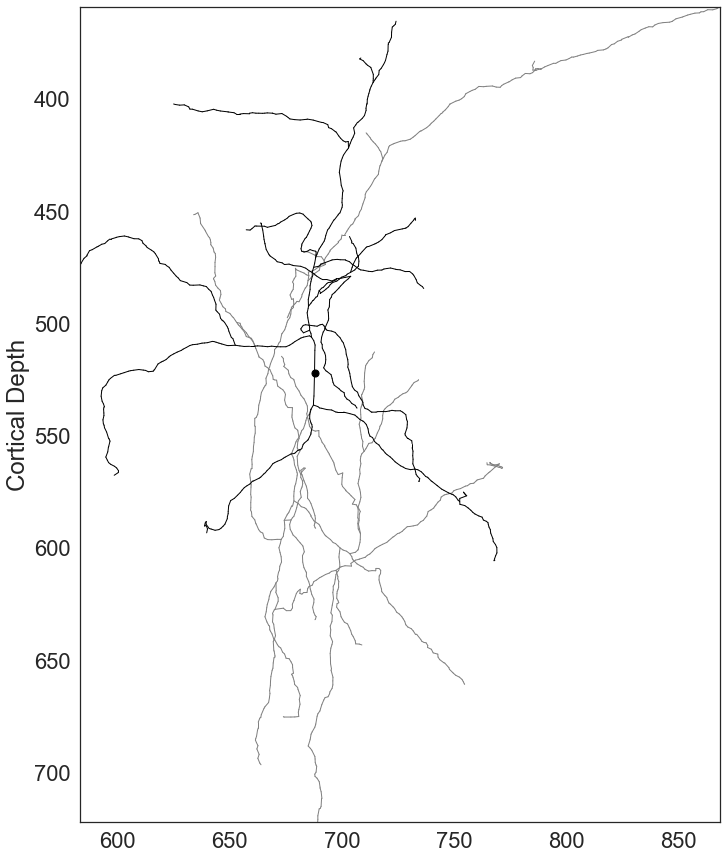

In [199]:
f, ax = plt.subplots(figsize=(12, 15))

skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True ,
                                      #radii=mw.skeleton.vertex_properties['radius']/200,
                                      invert_y=True,
                                      soma_size=50,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)

ax.set_ylabel('Cortical Depth')

Now let's add in the synapse information

In [200]:
#Downstream connectivity
syn_out_df = client.materialize.synapse_query(pre_ids=example_root_id,
                                             split_positions=True,
                                             materialization_version=661,
                                             desired_resolution=(1000,1000,1000))

Before we look at the profile we need to clean a few known errors that come with unproofread cells, mainly we want to look at how many nuclei belong to a single object (a result of false mergers), how many synapses are onto cell fragments (referred to as orphans), and how many objects are merged with glia. To do this, we will read in a precomputed dataframe that stores the number of nuclei per segmentation ID in v661 and the nature of the error

In [201]:
nuc_count = pd.read_pickle('../data/nucleus_counts_perID_v661.pkl')

In [202]:
example_out_df = syn_out_df.merge(nuc_count, left_on='post_pt_root_id', right_index=True, how='left')

example_out_df=example_out_df.merge(mm_df[['id_ref', 'cell_type', 'pt_root_id']], 
                         left_on='first_nuc_id', 
                         right_on='id_ref', how='left')


example_out_df=example_out_df.query('n_neuron_det==1').merge(nuc_df[['id', 'pt_position_x', 'pt_position_y', 'pt_position_z']], left_on='first_nuc_id', right_on='id')

In [203]:
summary_d = {}
summary_d['Output synapses']=len(mw.anno.pre_syn)

example_out_count_df = syn_out_df.merge(nuc_count, left_on='post_pt_root_id', right_index=True, how='left')
summary_d['Single nucleus']=len(example_out_count_df.query('num_nuc_det==1'))
summary_d['Single neuron']=len(example_out_count_df.query('n_neuron_det==1'))
summary_d['Neuron Merge error']=len(example_out_count_df.query('n_neuron_det>1'))
summary_d['Neuron/Glia Merge error']=len(example_out_count_df.query('num_nuc_det>1'))
summary_d['Orphan']=len(example_out_count_df.query('n_neuron_det.isna()', engine='python'))

print('Output Synapse Summary')
summary_d

Output Synapse Summary


{'Output synapses': 480,
 'Single nucleus': 277,
 'Single neuron': 279,
 'Neuron Merge error': 0,
 'Neuron/Glia Merge error': 4,
 'Orphan': 201}

In [204]:
post_count = example_out_df.pt_root_id.value_counts().to_dict()
syn_size = example_out_df.groupby('pt_root_id')['size'].sum().to_dict()
    
example_out_df['post_count_size'] = example_out_df.pt_root_id.map(post_count)
example_out_df['sum_syn_size'] = example_out_df.pt_root_id.map(syn_size)

In [205]:
all_palette = color_dict
all_palette['Functional coregistered targets']='green'
all_palette['Orphan']=(.5,.5,.5)
all_palette['orphan']=(.5,.5,.5)
all_palette['other']=(.8,.8,.8)
all_palette['nonneuron']='green'
all_palette['Other']=(.8,.8,.8)
all_palette['excitatory']='lightblue'
all_palette['inhibitory']='purple'
for l in summary_d.keys():
    if l not in all_palette.keys():
        all_palette[l]=(0,0,0)

We can now use all of this information to look at the number of synapses from our example cell made onto neuronal subclasses

Text(0.5, 1.0, 'Downstream Connectivity Preferences for Example Cell')

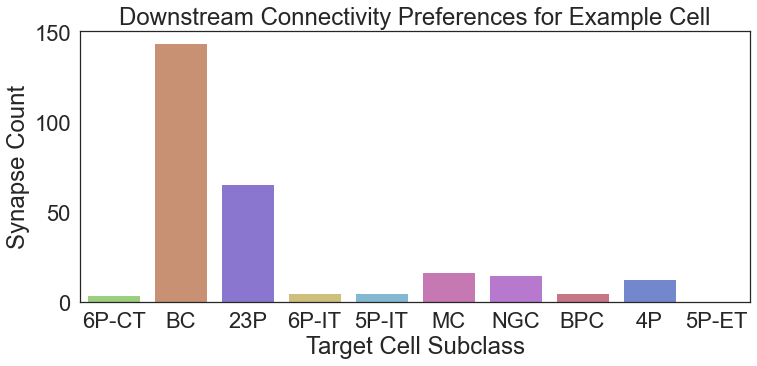

In [206]:
sns.set(style='white', font_scale =2)
f, ax = plt.subplots(figsize=(12,5))

nonneurons = ['microglia','OPC','astrocyte', 'oligo']
sns.countplot(data = example_out_df.query('cell_type not in @nonneurons'),
            x='cell_type',alpha=1,
            palette=all_palette)

ax.set_ylabel('Synapse Count')
ax.set_xlabel('Target Cell Subclass')
ax.set_title('Downstream Connectivity Preferences for Example Cell')

How many synapses does the example cell make with any one neuron from these different neuronal subclasses?

Text(0.5, 1.0, 'Number of Synapses per Connection')

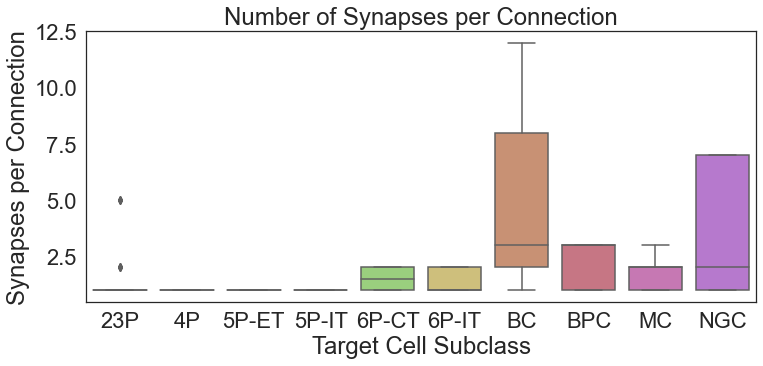

In [207]:
sns.set(style='white', font_scale =2)
f, ax = plt.subplots(figsize=(12,5))


sns.boxplot(data = example_out_df.query('cell_type not in @nonneurons').sort_values('cell_type'),
                 y='post_count_size', x='cell_type', palette = color_dict, ax=ax) 

ax.set_xlabel('Target Cell Subclass')
ax.set_ylabel('Synapses per Connection')
ax.set_title('Number of Synapses per Connection')


Based on previous literature, it is thought the larger the synapse PSD area, they stronger the connection between the two cells. Using the predicted synapse area as a proxy to PSD area, how does the overall sum of synapse area per connection vary by cell-type?

Text(0.5, 1.0, 'Synapse Area Per Connection')

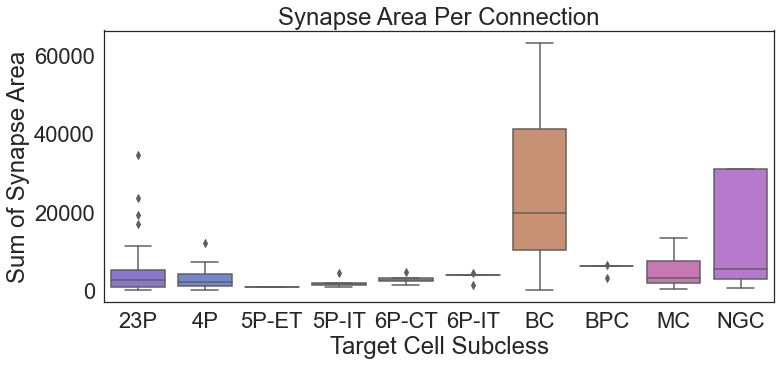

In [208]:
sns.set(style='white', font_scale =2)
f, ax = plt.subplots(figsize=(12,5))

sns.boxplot(data = example_out_df.query('cell_type not in @nonneurons').sort_values('cell_type'),
                 y='sum_syn_size', x='cell_type', palette = color_dict, ax=ax) 

ax.set_xlabel('Target Cell Subcless')
ax.set_ylabel('Sum of Synapse Area')
ax.set_title('Synapse Area Per Connection')

Finally, we can look at these synapses onto the axon of the cell itself. Below we are plotting each output synapse colored by the predicted subclass of the postsynaptic target cell.

Text(0.5, 0, '')

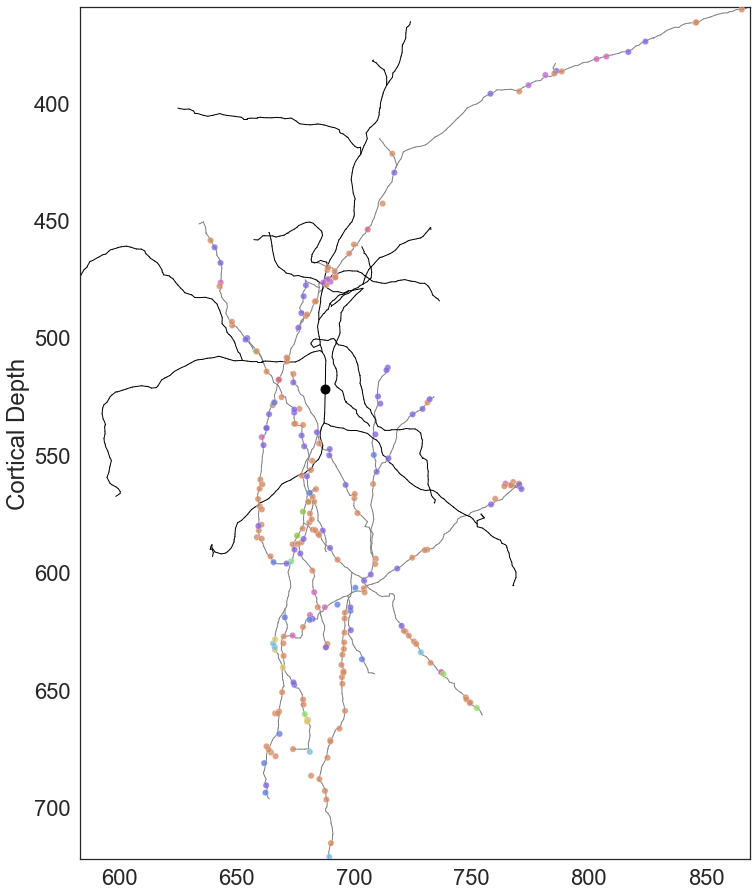

In [209]:
f, ax = plt.subplots(figsize=(12,17))

#Plotting output synapses colored by predicted target subclass
sns.scatterplot(data = example_out_df.query('id_x in @axon_syn_ids'),
                 x='pre_pt_position_x', y='pre_pt_position_y', hue = 'cell_type',
                 s=40, alpha=0.8, linewidth=0.3,
                 ax=ax, palette=all_palette, legend=False, zorder=25)  


skel_cmap = {
    0:'gray',
    1:'black',
    3:'black',
    4: 'black'
}
#Plotting example cell skeleton
skeleton_plot.plot_tools.plot_mw_skel(mw, 
                                      plot_soma=True,
                                      invert_y=True,
                                      soma_size=80,
                                      skel_colors=skel_clist,
                                     skel_color_map=skel_cmap)



ax.set_aspect('equal')
ax.set_ylabel('Cortical Depth')
ax.set_xlabel('')